In [1]:
import artm

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import sys
sys.path.append('..')
sys.path.append('../..')

from library import TopicPriorRegularizer, SemanticHeterogenityRegularizer, custom_fit_offline
from library import ModelStatistics, BleiTopTokens

In [2]:
DATA_PATH = '../data/lenta_1000_100.vw'
BATCH_PATH = '../data/lenta_1000_100_batches'
DICT_PATH = '../data/lenta_1000_100.dict'

batch_vectorizer_lenta = artm.BatchVectorizer(
    data_path=DATA_PATH,
    data_format='vowpal_wabbit', 
    target_folder=BATCH_PATH
)

dictionary_lenta = artm.Dictionary()
if not os.path.isfile(DICT_PATH):
    dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
    dictionary_lenta.save(DICT_PATH)
dictionary_lenta.load(DICT_PATH)

## Topic prior regularizer

In [3]:
model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

custom_regularizers = [
    TopicPriorRegularizer('topic_prior', 2, beta=[0.1, 0.9])
]

custom_fit_offline(model_lenta, custom_regularizers, batch_vectorizer_lenta, 10)

In [4]:
model_lenta_unbalanced = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta_unbalanced.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta_unbalanced.initialize(dictionary_lenta)

model_lenta_unbalanced.fit_offline(batch_vectorizer_lenta, 10)

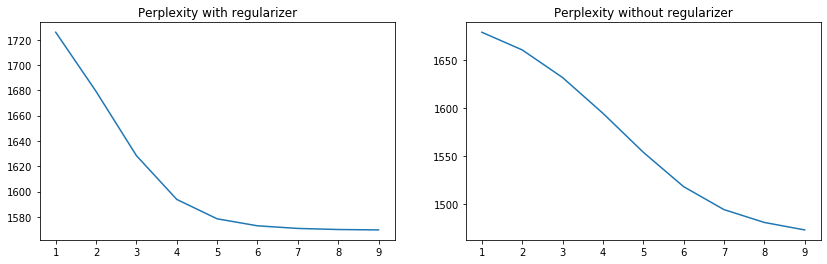

In [5]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
values = np.array(model_lenta.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity with regularizer')
plt.plot(values)

plt.subplot(1,2,2)
values = np.array(model_lenta_unbalanced.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

In [6]:
top_tokens = BleiTopTokens(num_top_tokens=20).view(model_lenta.get_phi())

top_tokens

{'topic_0': {'values': array([0.7944808 , 0.28397793, 0.21742373, 0.17719276, 0.14399273,
         0.11597186, 0.10600322, 0.10256787, 0.08815011, 0.07749353,
         0.05736777, 0.05456609, 0.04360125, 0.04205048, 0.04097373,
         0.03755339, 0.03733914, 0.03719835, 0.03650766, 0.02841116]),
  'tokens': [('text', '.'),
   ('ngramms', '<person>_<person>'),
   ('text', '<person>'),
   ('ngramms', 'миллиард_рубль'),
   ('text', 'год'),
   ('text', 'компания'),
   ('text', 'что'),
   ('ngramms', 'миллиард_доллар'),
   ('text', 'В'),
   ('text', 'быть'),
   ('ngramms', 'миллион_доллар'),
   ('text', 'процент'),
   ('text', 'миллиард'),
   ('ngramms', 'процент_акция'),
   ('ngramms', 'пресс_релиз'),
   ('text', 'рубль'),
   ('text', 'россия'),
   ('text', 'российский'),
   ('ngramms', 'миллион_рубль'),
   ('text', 'миллион')]},
 'topic_1': {'values': array([0.05365356, 0.01620834, 0.00564939, 0.00526364, 0.00443376,
         0.00379147, 0.00355573, 0.00271659, 0.00271648, 0.00269748,
 

In [7]:
unbalanced_top_tokens = BleiTopTokens(num_top_tokens=20).view(model_lenta_unbalanced.get_phi())

unbalanced_top_tokens

{'topic_0': {'values': array([1.49591932, 0.63121543, 0.43788475, 0.38205045, 0.35586638,
         0.3338151 , 0.29998855, 0.20755139, 0.20057104, 0.19554947,
         0.19035631, 0.16812195, 0.15359521, 0.15203565, 0.13620949,
         0.10457361, 0.09753865, 0.09131999, 0.08434176, 0.08196134]),
  'tokens': [('text', '.'),
   ('ngramms', 'миллиард_рубль'),
   ('ngramms', '<person>_<person>'),
   ('text', '<person>'),
   ('text', 'год'),
   ('ngramms', 'миллиард_доллар'),
   ('text', 'компания'),
   ('text', 'что'),
   ('text', 'процент'),
   ('ngramms', 'миллион_доллар'),
   ('text', 'В'),
   ('ngramms', 'процент_акция'),
   ('text', 'быть'),
   ('text', 'миллиард'),
   ('text', 'рубль'),
   ('ngramms', 'миллион_рубль'),
   ('ngramms', 'пресс_релиз'),
   ('text', 'доллар'),
   ('text', 'миллион'),
   ('text', 'акция')]},
 'topic_1': {'values': array([1.29120554, 0.70799959, 0.55359932, 0.21605713, 0.18402898,
         0.16509006, 0.16181467, 0.13672649, 0.08754144, 0.08249693,
      

## Semantic heterogenity regularizer ($\tau$=0.1)

In [9]:
model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

model_lenta.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi'))
model_lenta.regularizers['decorrelator_phi'].tau = 1e+5

statistics = ModelStatistics(model_lenta)
custom_regularizers = [
    SemanticHeterogenityRegularizer('heterogenity', 0.1, statistics, batch_vectorizer_lenta)
]

custom_fit_offline(model_lenta, custom_regularizers, batch_vectorizer_lenta, 20)

In [10]:
model_lenta_unbalanced = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta_unbalanced.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta_unbalanced.initialize(dictionary_lenta)

model_lenta_unbalanced.fit_offline(batch_vectorizer_lenta, 20)

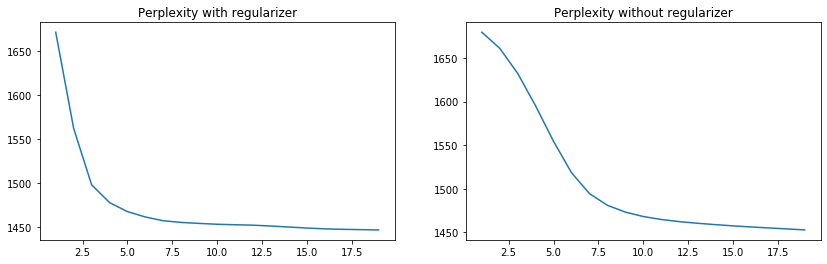

In [11]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
values = np.array(model_lenta.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity with regularizer')
plt.plot(values)

plt.subplot(1,2,2)
values = np.array(model_lenta_unbalanced.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

In [12]:
top_tokens = BleiTopTokens(num_top_tokens=20).view(model_lenta.get_phi())

top_tokens

{'topic_0': {'values': array([0.72878566, 0.26139159, 0.2330265 , 0.20281316, 0.15948656,
         0.14669844, 0.14262654, 0.09925126, 0.08701512, 0.08197485,
         0.07777224, 0.07293594, 0.06990297, 0.06153877, 0.05257548,
         0.0446184 , 0.03895019, 0.03866673, 0.03717664, 0.03655097]),
  'tokens': [('text', '.'),
   ('ngramms', 'миллиард_рубль'),
   ('ngramms', '<person>_<person>'),
   ('text', '<person>'),
   ('text', 'год'),
   ('ngramms', 'миллиард_доллар'),
   ('text', 'компания'),
   ('text', 'что'),
   ('text', 'В'),
   ('text', 'процент'),
   ('ngramms', 'миллион_доллар'),
   ('ngramms', 'процент_акция'),
   ('text', 'быть'),
   ('text', 'миллиард'),
   ('text', 'рубль'),
   ('ngramms', 'пресс_релиз'),
   ('text', 'доллар'),
   ('text', 'россия'),
   ('ngramms', 'миллион_рубль'),
   ('text', 'миллион')]},
 'topic_1': {'values': array([0.69796014, 0.34974161, 0.28569546, 0.10850798, 0.10357183,
         0.08253356, 0.08165162, 0.06768925, 0.03938825, 0.0383863 ,
     

In [13]:
unbalanced_top_tokens = BleiTopTokens(num_top_tokens=20).view(model_lenta_unbalanced.get_phi())

unbalanced_top_tokens

{'topic_0': {'values': array([2.46787277, 1.10122369, 0.7723664 , 0.67555943, 0.62324203,
         0.60307046, 0.54181047, 0.36335175, 0.36157159, 0.34730479,
         0.33622768, 0.30298944, 0.27424274, 0.26707752, 0.25052534,
         0.19743877, 0.176278  , 0.1761418 , 0.16480999, 0.15100118]),
  'tokens': [('text', '.'),
   ('ngramms', 'миллиард_рубль'),
   ('ngramms', '<person>_<person>'),
   ('text', '<person>'),
   ('text', 'год'),
   ('ngramms', 'миллиард_доллар'),
   ('text', 'компания'),
   ('text', 'процент'),
   ('text', 'что'),
   ('ngramms', 'миллион_доллар'),
   ('text', 'В'),
   ('ngramms', 'процент_акция'),
   ('text', 'миллиард'),
   ('text', 'быть'),
   ('text', 'рубль'),
   ('ngramms', 'миллион_рубль'),
   ('ngramms', 'пресс_релиз'),
   ('text', 'доллар'),
   ('text', 'миллион'),
   ('text', 'россия')]},
 'topic_1': {'values': array([2.40812136, 1.27925117, 1.00641589, 0.41779632, 0.35119981,
         0.32521336, 0.31242251, 0.24542891, 0.16982708, 0.16168029,
     

## Semantic heterogenity regularizer ($\tau$=1)

In [13]:
model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

statistics = ModelStatistics(model_lenta)
custom_regularizers = [
    SemanticHeterogenityRegularizer('heterogenity', 1, statistics, batch_vectorizer_lenta)
]

custom_fit_offline(model_lenta, custom_regularizers, batch_vectorizer_lenta, 10)

In [14]:
model_lenta_unbalanced = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta_unbalanced.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta_unbalanced.initialize(dictionary_lenta)

model_lenta_unbalanced.fit_offline(batch_vectorizer_lenta, 10)

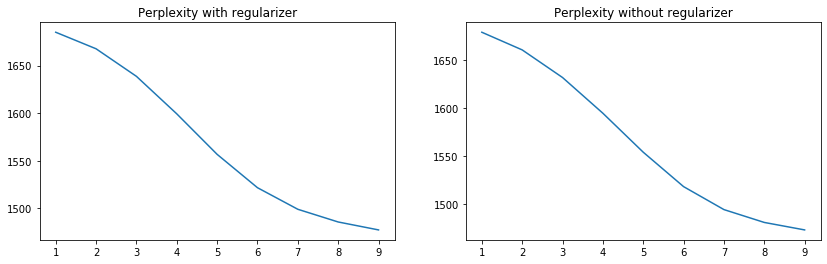

In [15]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
values = np.array(model_lenta.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity with regularizer')
plt.plot(values)

plt.subplot(1,2,2)
values = np.array(model_lenta_unbalanced.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

In [15]:
top_tokens = BleiTopTokens(num_top_tokens=20).view(model_lenta.get_phi())

top_tokens

{'topic_0': {'values': array([1.04502221, 0.22210352, 0.15407472, 0.14849626, 0.14238983,
         0.13601509, 0.09503445, 0.09142261, 0.08793677, 0.08748472,
         0.07350841, 0.0472208 , 0.03795204, 0.03394298, 0.03318733,
         0.02742143, 0.02614169, 0.02397328, 0.02322918, 0.02274233]),
  'tokens': [('text', '.'),
   ('ngramms', 'миллиард_рубль'),
   ('text', '<person>'),
   ('text', 'год'),
   ('ngramms', 'миллиард_доллар'),
   ('ngramms', '<person>_<person>'),
   ('text', 'что'),
   ('text', 'В'),
   ('ngramms', 'миллион_доллар'),
   ('text', 'быть'),
   ('text', 'компания'),
   ('text', 'процент'),
   ('text', 'миллиард'),
   ('ngramms', 'генеральный_директор'),
   ('text', 'как'),
   ('text', 'российский'),
   ('text', 'рубль'),
   ('text', 'россия'),
   ('ngramms', 'российский_компания'),
   ('ngramms', 'В_настоящее_время')]},
 'topic_1': {'values': array([0.45648949, 0.31196649, 0.1445682 , 0.0994574 , 0.08529308,
         0.08240022, 0.07642501, 0.07561471, 0.06519225

In [16]:
unbalanced_top_tokens = BleiTopTokens(num_top_tokens=20).view(model_lenta_unbalanced.get_phi())

unbalanced_top_tokens

{'topic_0': {'values': array([1.49591932, 0.63121543, 0.43788475, 0.38205045, 0.35586638,
         0.3338151 , 0.29998855, 0.20755139, 0.20057104, 0.19554947,
         0.19035631, 0.16812195, 0.15359521, 0.15203565, 0.13620949,
         0.10457361, 0.09753865, 0.09131999, 0.08434176, 0.08196134]),
  'tokens': [('text', '.'),
   ('ngramms', 'миллиард_рубль'),
   ('ngramms', '<person>_<person>'),
   ('text', '<person>'),
   ('text', 'год'),
   ('ngramms', 'миллиард_доллар'),
   ('text', 'компания'),
   ('text', 'что'),
   ('text', 'процент'),
   ('ngramms', 'миллион_доллар'),
   ('text', 'В'),
   ('ngramms', 'процент_акция'),
   ('text', 'быть'),
   ('text', 'миллиард'),
   ('text', 'рубль'),
   ('ngramms', 'миллион_рубль'),
   ('ngramms', 'пресс_релиз'),
   ('text', 'доллар'),
   ('text', 'миллион'),
   ('text', 'акция')]},
 'topic_1': {'values': array([1.29120554, 0.70799959, 0.55359932, 0.21605713, 0.18402898,
         0.16509006, 0.16181467, 0.13672649, 0.08754144, 0.08249693,
      

## Semantic heterogenity regularizer ($\tau$=10)

In [18]:
model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(dictionary_lenta)

statistics = ModelStatistics(model_lenta)
custom_regularizers = [
    SemanticHeterogenityRegularizer('heterogenity', 10, statistics, batch_vectorizer_lenta)
]

custom_fit_offline(model_lenta, custom_regularizers, batch_vectorizer_lenta, 10)

KeyboardInterrupt: 

In [ ]:
model_lenta_unbalanced = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta_unbalanced.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta_unbalanced.initialize(dictionary_lenta)

model_lenta_unbalanced.fit_offline(batch_vectorizer_lenta, 10)

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
values = np.array(model_lenta.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity with regularizer')
plt.plot(values)

plt.subplot(1,2,2)
values = np.array(model_lenta_unbalanced.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

In [ ]:
top_tokens = BleiTopTokens(num_top_tokens=20).view(model_lenta.get_phi())

top_tokens

In [ ]:
unbalanced_top_tokens = BleiTopTokens(num_top_tokens=20).view(model_lenta_unbalanced.get_phi())

unbalanced_top_tokens

---